# Import thư viện

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import warnings

import lightgbm as lgb
from unidecode import unidecode
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from itertools import combinations
from datetime import datetime

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50
plt.style.use('ggplot')

%matplotlib inline

In [8]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [9]:
print(df_train.shape)
print(df_test.shape)

(53030, 195)
(20381, 194)


# Loại bỏ outlier

In [10]:
# def process_outlier(df):

#     cols = ['Field_{}'.format(i) for i in [20, 23, 27, 28, 63, 67, 74, 81]] + ['friendCount', 'subscriberCount']
#     for col in cols:
#         bool_null = df[col].isnull()
#         df_not_null = df[~bool_null]
#         df_null = df[bool_null]
#         # remove outlier upperbound
#         upper_bound = df_not_null[col].quantile(0.99)
#         df_not_null = df_not_null[df_not_null[col]<upper_bound]
#         df = pd.concat([df_not_null,df_null], 0)
#         print(df.shape)
        
#     df.id = np.arange(0, df.shape[0])
#     return df

In [11]:
# df_train = process_outlier(df_train.copy())

In [12]:
df_train

,id,label,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,Field_9,Field_10,Field_11,Field_12,Field_13,Field_14,Field_15,Field_16,Field_17,Field_18,Field_19,Field_20,Field_21,Field_22,Field_23,...,partner4_C,partner4_D,partner4_E,partner4_F,partner4_G,partner4_H,partner4_K,partner4_L,partner5_A,partner5_B,partner5_C,partner5_D,partner5_E,partner5_F,partner5_G,partner5_H,partner5_K,partner5_L,brief,num_of_phone,Field_78,Field_79,Field_80,Field_81,Field_82
0,0,1,2019-07-24T03:39:02.854Z,2019-07-31T20:10:02Z,1.0,GH,2018-12-27,2018-12-27,2019-01-01,2019-07-31,2018-12-27,1.0,2019-07-31,G8,1.0,1.0,NaN,1.0,1.0,Trung tâm Kinh doanh tiền mặt,0.0,4258600.0,4.5,1.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cb1,1.0,NaN,NaN,NaN,NaN,1
1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.0,NaN,NaN,NaN,NaN,1
2,2,0,2019-01-17T07:15:26.367Z,2019-01-17T07:17:45Z,2.0,T1,2019-01-17,2019-01-17,2019-01-01,2019-12-31,2019-01-17,1.0,NaN,NaN,1.0,1.0,2019-01-17,1.0,1.0,NaN,0.0,5000000.0,4.5,1.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,33.0,10.769445,6.466667,0.0,2
3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3
4,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53025,53025,0,2019-12-24T15:39:31.156Z,2019-12-24T15:40:44Z,1.0,GH,2019-12-24,2019-12-24,2020-01-01,2020-12-31,2019-12-24,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1490000.0,4.5,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,202.0,157.837469,14.000000,-183.0,1
53026,53026,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notfound,1.0,26.0,10.246951,12.500000,2.0,1
53027,53027,0,2017-11-11T17:15:01.948Z,2017-11-11T17:15:01.948Z,2.0,T1,2017-07-22,2017-07-22,2017-07-01,2017-11-30,2017-07-22,1.0,2017-11-30,G8,1.0,1.0,2017-07-24,1.0,1.0,36493ASSYD,0.0,4015000.0,4.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notfound,1.0,NaN,NaN,NaN,NaN,1
53028,53028,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notfound,1.0,NaN,NaN,NaN,NaN,4


In [13]:
df_all = df_train.drop(['label'], 1).append(df_test)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 0 to 20380
Columns: 194 entries, id to Field_82
dtypes: float64(133), int64(2), object(59)
memory usage: 109.2+ MB


# Xử lí với kiểu dữ liệu là categorical

## Xử lí với kiểu dữ liệu là ngày

In [14]:
DATE = ["Field_{}".format(i) for i in [5, 7, 8, 15, 32, 33, 40]]
DATETIME = ["Field_{}".format(i) for i in [1, 43, 44]]
# df_all[DATE + DATETIME + ["Field_34", "ngaySinh"]].sample(10)

In [15]:
def combine_field_1_2(s):
    x, y = s
    if x != x and y != y:
        return np.nan
    
    if x != x:
        return y
    
    return x


def field1_field2_combination(df):
    df['Field_1'] = df['Field_1'].apply(lambda x: str(x)[:10] if x==x else x)
    df['Field_2'] = df['Field_2'].apply(lambda x: str(x)[:10] if x==x else x)
    df["Field_1"] = df[['Field_1', 'Field_2']].apply(combine_field_1_2, axis=1)
    return df
    

In [16]:
def datetime_normalize_and_fillna(df):
    df = field1_field2_combination(df)
    
    for col in DATETIME:
        df[col] = pd.to_datetime(df[col], format = '%Y-%m-%d')
        val_count_year = df[col].dt.year.value_counts()
        dis_year = val_count_year/sum(val_count_year)
        df[col+'_year'] = df[col].dt.month.apply(lambda x: float(np.random.choice(list(val_count_year.index),
                                                                                   p = dis_year)) if x!=x else x)
        df[col+'_month'] = df[col].dt.month.apply(lambda x: float(np.random.randint(12)+1) if x!=x else x)
        df[col+'_day'] = df[col].dt.day.apply(lambda x: float(np.random.randint(30)+1) if x!=x else x)
        
    return df
                                                  

In [17]:
%%time
def date_normalize(s):
    if s != s:
        return np.nan
    
    try:
        datetime_obj = datetime.strptime(s, "%m/%d/%Y")
    except:
        datetime_obj = datetime.strptime(s, "%Y-%m-%d")
        
    return datetime_obj


def date_process_and_fillna(df):
    for col in DATE:
        df[col] = df[col].apply(date_normalize)
        # day
        val_count_day = df[col].dt.day.value_counts()
        dis_day = val_count_day/sum(val_count_day)
        df[col+'_day'] = df[col].dt.month.apply(lambda x: float(np.random.choice(list(val_count_day.index),
                                                                                   p = dis_day)) if x!=x else x)
        #month
        val_count_month = df[col].dt.month.value_counts()
        dis_month = val_count_month/sum(val_count_month)
        df[col+'_month'] = df[col].dt.month.apply(lambda x: float(np.random.choice(list(val_count_month.index),
                                                                                   p = dis_month)) if x!=x else x)
        
        # year
        val_count_year = df[col].dt.year.value_counts()
        dis_year = val_count_year/sum(val_count_year)
        df[col+'_year'] = df[col].dt.month.apply(lambda x: float(np.random.choice(list(val_count_year.index),
                                                                                   p = dis_year)) if x!=x else x)
                                                                                   
    return df

Wall time: 0 ns


In [18]:
def correct_34_ngaysinh(s):
    if s != s:
        return np.nan
    try:
        s = int(s)
    except ValueError:
        s = s.split(" ")[0]
        
    return datetime.strptime(str(s)[:6], "%Y%m")

def process_34_ngaysinh(df):
    df["Field_34"] = df["Field_34"].apply(correct_34_ngaysinh)
    df["ngaySinh"] = df["ngaySinh"].apply(correct_34_ngaysinh)
    for col in ['Field_34', 'ngaySinh']:
        #month
        val_count_month = df[col].dt.month.value_counts()
        dis_month = val_count_month/sum(val_count_month)
        df[col+'_month'] = df[col].dt.month.apply(lambda x: float(np.random.choice(list(val_count_month.index),
                                                                                   p = dis_month)) if x!=x else x)
        
        # year
        val_count_year = df[col].dt.year.value_counts()
        dis_year = val_count_year/sum(val_count_year)
        df[col+'_year'] = df[col].dt.month.apply(lambda x: float(np.random.choice(list(val_count_year.index),
                                                                                   p = dis_year)) if x!=x else x)
    
    return df
    

In [19]:
alpha_startDate = ['{}_startDate'.format(c) for c in ['F', 'E', 'C', 'G', 'A']] 
alpha_endDate = ['{}_endDate'.format(c) for c in ['F', 'E', 'C', 'G', 'A']]

def process_alpha_date(df):
    for col in alpha_startDate:
        df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
        #month
        val_count_month = df[col].dt.month.value_counts()
        dis_month = val_count_month/sum(val_count_month)
        df[col+'_month'] = df[col].dt.month.apply(lambda x: float(np.random.choice(list(val_count_month.index),
                                                                                   p = dis_month)) if x!=x else x)
        # year
        val_count_year = df[col].dt.year.value_counts()
        dis_year = val_count_year/sum(val_count_year)
        df[col+'_year'] = df[col].dt.year.apply(lambda x: float(np.random.choice(list(val_count_year.index),
                                                                                   p = dis_year)) if x!=x else x)
    
    for col in alpha_endDate:
        df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
        #month
        val_count_month = df[col].dt.month.value_counts()
        dis_month = val_count_month/sum(val_count_month)
        df[col+'_month'] = df[col].dt.month.apply(lambda x: float(np.random.choice(list(val_count_month.index),
                                                                                   p = dis_month)) if x!=x else x)
        # year
        val_count_year = df[col].dt.year.value_counts()
        dis_year = val_count_year/sum(val_count_year)
        df[col+'_year'] = df[col].dt.year.apply(lambda x: float(np.random.choice(list(val_count_year.index),
                                                                                   p = dis_year)) if x!=x else x)
        
    
    # Extra Featuring 
    for i in range(len(alpha_endDate)):
        df[alpha_startDate[i]+'_diffDay'] = df[alpha_endDate[i]].dt.day - df[alpha_startDate[i]].dt.day
        
    return df
                                              

In [20]:
def process_datetime_cols(df):
    DROP = ['Field_2', 'Field_6', 'Field_9', 'Field_11', 'Field_25', 'Field_35']
    df = datetime_normalize_and_fillna(df)
    df = date_process_and_fillna(df)
    df = process_34_ngaysinh(df)
    df = process_alpha_date(df)
    
    return df.drop(DROP+DATE+DATETIME+['Field_34', 'ngaySinh'] + alpha_startDate + alpha_endDate, 1)
    

In [21]:
%%time
df = process_datetime_cols(df_all.copy())

Wall time: 1min 38s


## Xử lí các thuộc tính khác

In [22]:
def str_normalize(s):
    if s==s:
        s = str(s).strip().lower()
        s = re.sub(' +', " ", s)
    return s


def job_category(x):
    if type(x) == str:
        if "công nhân" in x or "cnv" in x or "cn" in x or "may công nghiệp" in x or "lao động" in x\
        or "thợ" in x or "coõng nhaõn trửùc tieỏp maựy may coõng nghieọp" in x or "c.n" in x or "lđ" in x:
            return "CN"
        elif "giáo viên" in x or "gv" in x or "gíao viên" in x:
            return "GV"
        elif "nhân viên" in x or "kế toán" in x or "cán bộ" in x or "nv" in x or "cb" in x or "nhõn viờn" in x:
            return "NV"
        elif "tài xế" in x or "lái" in x or "tài xê" in x:
            return "TX"
        elif "quản lý" in x or "phó phòng" in x or "hiệu phó" in x:
            return "QL"
        elif "undefined" in x:
            return "missing"
        elif "giám đốc" in x or "hiệu trưởng" in x:
            return "GĐ"
        elif "phục vụ" in x:
            return "PV"
        elif "chuyên viên" in x:
            return  "CV"
        elif "bác sĩ" in x or "dược sĩ" in x or "y sĩ" in x or "y sỹ" in x:
            return "BS"
        elif "y tá" in x:
            return "YT"
        elif "hộ sinh" in x:
            return "HS"
        elif "chủ tịch" in x:
            return "CT"
        elif "bếp" in x:
            return "ĐB"
        elif "sư" in x:
            return "KS"
        elif "dưỡng" in x:
            return "ĐD"
        elif "kỹ thuật" in x or "kĩ thuật" in x:
            return "KTV"
        elif "diễn viên" in x:
            return "DV"
        else:
            return 'other'
    else:
        return x    
    

In [23]:
def combine_gender(s):
    x, y = s
    
    if x != x and y != y:
        return np.nan
    
    if x != x:
        return y.lower()
    
    return x.lower()

def process_gender(df):
    df["gender"] = df[["gioiTinh", "info_social_sex"]].apply(combine_gender, axis=1)
    return df

In [24]:
def field_18_category(x):
    if type(x)==str:
        if 'congty' in x or 'cty' in x or 'kinh doanh' in x or 'phòng' in x or 'xưởng' in x:
            return 'congty'
        elif x.isdigit() or '-' in x or '_' in x or '/' in x:
            return 'code'
        else:
            return 'other'
    else:
        return x

In [25]:
def diaChi_category(x):
    if type(x) == str:
        if 'hà nội' in x or 'tp.hà nội' in x:
            return 'HN'
        elif 'hồ chí minh' in x or 'hcm' in x:
            return 'HCM'
        elif 'an giang' in x or x=='ag':
            return 'AG'
        elif 'vũng tàu' in x:
            return 'VT'
        elif 'bắc giang' in x:
            return 'BG'
        elif 'bắc kạn' in x:
            return 'BK'
        elif 'bạc liêu' in x:
            return 'BL'
        elif 'bắc ninh' in x:
            return 'BN'
        elif 'bến tre' in x:
            return 'BT'
        elif 'bình định' in x:
            return 'BĐ'
        elif 'bình dương' in x:
            return 'BD'
        elif 'bình phước' in x:
            return 'BP'
        elif 'bình thuận' in x:
            return 'BT'
        elif 'cà mau' in x:
            return 'CM'
        elif 'cần thơ' in x:
            return 'CT'
        elif 'cao bằng' in x:
            return 'CB'
        elif 'đà nẵng' in x or x=='đn':
            return 'ĐN'
        elif 'đắk lắk' in x:
            return 'ĐL'
        elif 'đắk nông' in x:
            return 'ĐN'
        elif 'điện biên' in x:
            return 'ĐB'
        elif 'đồng nai' in x:
            return 'ĐN'
        elif 'đồng tháp' in x:
            return 'ĐT'
        elif 'gia lai' in x:
            return 'GL'
        elif 'hà giang' in x:
            return 'HG'
        elif 'hà nam' in x:
            return 'HN1'
        elif 'hà tĩnh' in x:
            return 'HT'
        elif 'hải dương' in x:
            return 'HD'
        elif 'hải phòng' in x:
            return 'HP'
        elif 'hậu giang ' in x:
            return 'HG1'
        elif 'hòa bình' in x:
            return 'HB'
        elif 'hưng yên' in x:
            return 'HY'
        elif 'khánh hòa' in x:
            return 'KH'
        elif 'kiên giang' in x:
            return 'KG'
        elif 'kon tum' in x:
            return 'KT'
        elif 'lai châu' in x:
            return 'LC'
        elif 'lâm đồng ' in x or x =='lđ':
            return 'LĐ'
        elif 'lạng sơn' in x:
            return 'LS'
        elif 'lào cai' in x:
            return 'LC'
        elif 'long an' in x:
            return 'LA'
        elif 'nam định' in x:
            return 'NĐ'
        elif 'nghệ an' in x:
            return 'NA'
        elif 'ninh bình' in x:
            return 'NB'
        elif 'ninh thuận' in x:
            return 'NT'
        elif 'phú thọ' in x:
            return 'PT'
        elif 'phú yên' in x:
            return 'PY'
        elif 'quảng bình' in x:
            return 'QB'
        elif 'quảng nam' in x:
            return 'QN'
        elif 'quảng ngãi' in x:
            return 'QN1'
        elif 'quảng ninh' in x:
            return 'QN2'
        elif 'quảng trị' in x:
            return 'QT'
        elif 'sóc trăng' in x:
            return 'ST'
        elif 'sơn la' in x:
            return 'SL'
        elif 'tây ninh' in x:
            return 'TN'
        elif 'thái bình' in x:
            return 'TB'
        elif 'thái nguyên' in x:
            return 'TN1'
        elif 'thanh hóa' in x:
            return 'TH'
        elif 'thừa thiên huế' in x:
            return 'TTH'
        elif 'tiền giang' in x or x=='tg':
            return 'TG'
        elif 'trà vinh' in x:
            return 'TV'
        elif 'tuyên quang' in x:
            return 'TQ'
        elif 'vĩnh long' in x:
            return 'VL'
        elif 'vĩnh phúc' in x:
            return 'VP'
        elif 'yên bái' in x:
            return 'YB'
        elif 'cty' in x or 'công ty' in x:
            return 'congty'
        elif 'trường' in x or 'viện' in x or '':
            return 'KH'
        elif 'việc làm' in x:
            return 'DV_VL'
        else: 
            return 'other'
    else:
        return x
    
def diaChi_feature_process(df):
    main_location = df['diaChi'].apply(lambda x: x.split(',')[-1] if x == x else x).apply(str_normalize)
    df['diaChi'] = main_location.apply(diaChi_category)
    return df

In [26]:
def field_46_category(x):
    if type(x) == str:
        if 'công ty' in x or 'cty' in x:
            return 'CT'
        elif 'trường' in x:
            return 'TH'
        elif 'đại lý' in x or 'đại lí' in x:
            return 'ĐL'
        elif 'hộ gia đình' in x:
            return 'HGĐ'
        elif 'y tế' in x:
            return 'YT'
        else: return 'other'
    else:
        return x

In [27]:
%%time
def processing_and_normalize_dtype_categorical(df):
    df['Field_10'] = df['Field_10'].apply(lambda x: np.nan if x==0 else x)
    df['Field_18'] = df['Field_18'].apply(lambda x: np.nan if x=='.' else x)
    
    dict_field_19 = dict(df['Field_19'].value_counts())
    df['Field_19'] = df['Field_19'].apply(lambda x: -1 if x==x and dict_field_19[x]<10 else x)
    
    df['Field_20'] = df['Field_20'].replace(0, np.nan)
    df['Field_36'] = df['Field_36'].apply(lambda x: 'BT' if x=='B3' else x)
    df['Field_38'] = df['Field_38'].apply(lambda x: 0 if x==0 else 1 if x==1 else np.nan)
    df['Field_47'] = df['Field_47'].map({"Zezo": 0, "One": 1, "Two": 2, "Three": 3, "Four": 4})
    df['Field_54'] = df['Field_54'].apply(lambda x: np.nan if x=='1' or x == ' P. Tân Phú' else x)
    df['Field_55'] = df['Field_55'].apply(lambda x: np.nan if x=='true' else x)
    df['Field_62'] = df['Field_62'].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5, "Ngoài quốc doanh Quận 7": np.nan})
    df['Field_65'] = df['Field_65'].apply(lambda x: np.nan if x=='5' else x)
    df['brief'] = df['brief'].apply(lambda x: np.nan if x=='notfound' else x)
        
        
    # string field
    df["Field_18"] = df["Field_18"].apply(str_normalize).apply(field_18_category)
    df["Field_46"] = df["Field_46"].apply(str_normalize).apply(field_46_category)
    df["maCv"] = df["maCv"].apply(str_normalize).apply(job_category)
    df = diaChi_feature_process(df)
    df = process_gender(df)
    
    return df
    
    

Wall time: 0 ns


In [28]:
%%time
df = processing_and_normalize_dtype_categorical(df) 

Wall time: 1.45 s


In [29]:
%%time
def one_hot_and_ordinal_feat(pdf_input):
    pdf_data = pdf_input.copy()
    dict_feat = {
        "Field_3": [1, 2],
        'Field_4': ['T1', 'GH', 'is_null'],
        'Field_10': [1, 2, 3, 4, 5, 'is_null'],
        'Field_12': ['G8', 'G3', 'GX', 'G7', 'G9', 'G2', 'G4', 'is_null'],
        'Field_18': ['congty', 'code', 'other', 'is_null'],
        'Field_21': [4.5, 0, 6, 3, 'is_null'],
        'Field_22': [1, 2, 0, 'is_null'],
        'Field_38':[0, 1, 'is_null'],
        'Field_39':[0, 1, 'is_null'],
        'Field_41':[0, 1, 'is_null'],
        'Field_42':[0, 1, 'is_null'],
        'Field_46':['CT', 'other', 'HGĐ', 'TH', 'ĐL', 'YT', 'is_null'],
        'Field_47':[0., 1, 2., 3., 4, 'is_null'],
        'Field_50':[0, 1, 'is_null'],
        'Field_51':[0, 1, 'is_null'],
        'Field_53':[0, 1, 'is_null'],
        'Field_58': [0, 2, 3, 4, 5, 'is_null'],
        'Field_61': ['Khối DN Ngoài quốc doanh', 'Khối DN có vốn DTNN ', 'Hộ gia đình', 'Khối HS, Đảng, Đoàn', 
                     'Trợ cấp bảo hiểm thất nghiệp', 'Khối DN Nhà Nước', 'Học sinh sinh viên',
                    'Hộ gia đình làm nông lâm ngư diêm nghiệp', 'Người sống tại vùng đặc biệt khó khăn', 
                    'Người dân tộc thiểu số sống vùng KK, ĐBKK', 'Đối tượng cận nghèo', 'Đối tượng nghèo', 
                    'Khối ngoài công lập', 'Khối phường xã, thị trấn,', 'Cán bộ phường xã không chuyên trách', 
                     'Người sống tại xã đảo, huyện đảo', 'Khối hợp tác xã', 'Thân nhân sĩ quan nghiệp vụ công an', 
                    'Bảo trợ xã hội', 'Đại biểu quốc hội, HĐNN', 'Hộ SXKD cá thể, tổ hợp tác', 'Hưu trí, trợ cấp mất sức lao động',
                    'Thân nhân người có công', 'Tham gia kháng chiến', 'Doanh nghiệp LLVT', 'Trẻ em dưới 6 tuổi',
                    'Cựu chiến binh', 'Hưởng chế độ thai sản', 'Người có công', 'Hưu trí, trợ cấp mất sức lao động do NSNN đóng', 
                    'Người đã hiến bộ phận cơ thể', 'Ốm đau dài ngày', 'Khối tạm dừng', 'Chất độc hóa học', 
                     'Tổ chức khác và cá nhân', 'is_null'],
        'Field_62': [1, 2, 3, 4, 5, 'is_null'],
        'Field_63': [2., 3.,  5.,  0.,  4.,  8.,  7.,  6.,  9., 43., 'is_null'],
        'Field_65': ['Vùng 1', 'Vùng 2','DN đầu tư NN (Vùng 1 có ĐT) {01->09, 15}', 'Vùng 3', 'Vùng 4',
                    'DN đầu tư NN (Vùng 3 có ĐT) {17, 18, 24, 26->28}',
                    'DN đầu tư NN (Vùng 2 có ĐT) {10->14, 16, 19->23, 25, 29}',
                    'DN đầu tư NN (Vùng 4 có ĐT)', 'DN tư nhân'],
        'Field_66': ['G','E', 'D', 'C', 'H', 'F', 'B', 'I', 'is_null'],
        'Field_73':[0, 1, 'is_null'],
        'Field_82': [1, 2, 3, 4],
        'topFriends': [1, 2, 3, 4, 'is_null'],
        'maCv': ['CN', 'GV','NV', 'TX', 'QL', 'missing', 'GĐ', 'PV', 'CV', 'BS', 'YT', 
                 'HS', 'CT', 'ĐB', 'KS', 'ĐD', 'KTV', 'DV', 'other', 'is_null'],
        'gender': ['male', 'female', 'is_null'],
        'partner0_A': [0, 1, 'is_null'],
        'partner0_C': [0, 1, 'is_null'],
        'partner0_D': [0, 1, 'is_null'],
        'partner0_E': [0, 1, 'is_null'],
        'partner0_F': [0, 1, 'is_null'],
        'partner0_G': [0, 1, 'is_null'],
        'partner0_H': [0, 1, 'is_null'],
        'partner1_A': [0, 1, 'is_null'],
        'partner1_C': [0, 1, 'is_null'],
        'partner1_H': [0, 1, 'is_null'],
        'partner2_A': [0, 1, 'is_null'],
        'partner2_C': [0, 1, 'is_null'],
        'partner2_D': [0, 1, 'is_null'],
        'partner2_E': [0, 1, 'is_null'],
        'partner2_F': [0, 1, 'is_null'],
        'partner2_H': [0, 1, 'is_null'],
        'partner3_A': [0, 1, 'is_null'],
        'partner3_D': [0, 1, 'is_null'],
        'partner3_E': [0, 1, 'is_null'],
        'partner4_L': [0, 1, 'is_null'],
        'partner5_A': [0, 1, 'is_null'],
        'partner5_D': [0, 1, 'is_null'],
        'partner5_E': [0, 1, 'is_null'],
        'partner5_F': [0, 1, 'is_null'],
        'partner5_G': [0, 1, 'is_null']
    }
    
    for cname in dict_feat.keys():
        ls_vals = dict_feat[cname]
        for val in ls_vals:
            try:
                new_name = "{}_{}".format(cname, str(val).lower().replace(" ", "_")\
                                                              .replace(":", "_")\
                                                              .replace("/", "_")\
                                                              .replace("-", "_"))

                if val == "is_null":
                    pdf_data[new_name] = pdf_data[cname].isnull().apply(lambda x: int(x))
                else:
                    pdf_data[new_name] = pdf_data[cname].apply(lambda x: int(x == val))
            except Exception as err:
                print("One hot for {}-{}. Error: {}".format(cname, val, err))                        
                
    return pdf_data.drop(dict_feat.keys(), 1)



Wall time: 0 ns


In [30]:
%%time
df_oneHot = one_hot_and_ordinal_feat(df.copy())

Wall time: 10.6 s


In [71]:
df_oneHot.shape

(73411, 422)

# Xử lí với kiểu dữ liệu là numerical

In [6]:
def process_numeric_feature(df):
    # fill mean
    cols_fill_mean = ['Field_{}'.format(i) for i in [20, 67, 71, 72, 74,  78, 79, 80]]
    cols_contain_num_str = [i for i in df.columns if 'num' in str(i)]
    cols_field_with_most_0 = ['Field_{}'.format(i) for i in [13, 14, 16, 19, 24, 27, 28, 30, 31, 57, 69, 81]]\
                            +['friendCount','subscriberCount']
    cols_fill_0 = cols_contain_num_str + cols_field_with_most_0    
    cols_log_transfrom = ['Field_{}'.format(i) for i in [20, 74, 79, 'friendCount', 'subscriberCount']]
    
    # Fill mean for null
    for col in cols_fill_mean:
        df[col] = df[col].fillna(df[col].mean())
    
    # Fill 0 for null
    for col in cols_fill_0:
        df[col] = df[col].fillna(0)
    
    # log transform for feature with skew distribution
    for col in cols_log_transfrom:
        if col == 'Field_20' or col =='Field_74':
            df[col] = np.log(df[col])
        else:
            df[col] = np.log(df[col]+1)
    
    cols_num = df.dtypes != object
    for col in df.columns[cols_num]:
        if df[col].isnull().sum()>0:
            df[col] = df[col].fillna(-1)
            
    return df

In [ ]:
df = process_numeric_feature(df)

# Featuring

In [33]:
%%time
def feature_engineering(df):
    cols_field_with_most_0 = ['Field_{}'.format(i) for i in [13, 14, 16, 19, 24, 27, 28, 30, 31, 57, 69, 81]]\
                                + ['friendCount','subscriberCount']
        
    cols_featuring = ['Field_{}'.format(i) for i in [19, 23, 29, 36, 54, 55, 59, 60, 70]] +['diaChi', 'brief']
                      
    for col in cols:
        df[ col + '_0_or_not'] =  df[col].apply(lambda x: 1 if x==0 else 0)
        
    n = df.shape[0]
    name = '_featuring'
    for col in cols_featuring:
        if df[col].dtypes == 'object':
            df[col] = df[col].fillna('is_null')
        else:
            df[col] = df[col].fillna(-1)
        
        feature_dict = dict(df[col].value_counts())
        df[col+name] = df[col].apply(lambda x: feature_dict[x]/n)
    
    df['Field_68'+name] = df['Field_68'].apply(lambda x: len(str(x)) if x==x else -1)
    
    return df.drop(cols_featuring+['Field_68'], 1)

Wall time: 0 ns


In [74]:
%%time
df = feature_engineering(df_oneHot.copy())

Wall time: 1.98 s


In [75]:
df.shape

(73411, 435)

# Feature selection

In [80]:
DROP_col_name = ['gioiTinh', 'info_social_sex', 'namSinh','currentLocationName', 'currentLocationState', 'homeTownCity',
                 'homeTownCountry', 'homeTownName', 'homeTownState', 'homeTownLongitude', 'homeTownLaitude', ]

DROP_field = ['Field_{}'.format(i) for i in [17, 24, 26, 37, 45, 48, 49, 52, 56]]

df = df.drop(DROP_col_name+DROP_field, 1)

In [81]:
df.shape

(73411, 417)

In [82]:
# df.to_csv('processing_data2.csv')

In [83]:
df

,id,Field_13,Field_14,Field_16,Field_20,Field_27,Field_28,Field_30,Field_31,Field_57,Field_62,Field_64,Field_67,Field_69,Field_71,Field_72,Field_74,Field_75,Field_76,Field_77,friendCount,subscriberCount,currentLocationLatitude,currentLocationLongitude,homeTownLatitude,...,Field_28_0_or_not,Field_30_0_or_not,Field_31_0_or_not,Field_57_0_or_not,Field_69_0_or_not,Field_81_0_or_not,friendCount_0_or_not,subscriberCount_0_or_not,Field_19_featuring,Field_23_featuring,Field_29_featuring,Field_36_featuring,Field_54_featuring,Field_55_featuring,Field_59_featuring,Field_60_featuring,Field_70_featuring,diaChi_featuring,currentLocationLocationId_featuring,homeTownLocationId_featuring,data.basic_info.locale_featuring,currentLocationCity_featuring,currentLocationCountry_featuring,brief_featuring,Field_68_featuring
0,0,1.0,1.0,1.0,4.258600e+06,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.184100e+05,0.00,0.245000,0.490000,1888.550602,5.0,0.0,2.0,0.0,0.0,-1.0000,-1.000,-1.0000,...,1,0,0,0,1,1,1,1,0.944096,0.005135,0.166106,0.280299,0.250753,0.008936,0.150795,0.150795,0.027993,0.029192,0.547997,0.547997,0.547997,0.741224,0.741224,0.014276,10
1,1,0.0,0.0,0.0,3.619303e+06,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,5.266323e+05,0.00,0.343666,0.151108,704.000000,6.0,2.0,2.0,0.0,0.0,-1.0000,-1.000,-1.0000,...,1,1,1,1,1,1,1,1,0.944096,0.528354,0.528354,0.528354,0.733364,0.529076,0.528354,0.528368,0.528354,0.528354,0.547997,0.547997,0.547997,0.741224,0.741224,0.035145,-1
2,2,1.0,1.0,1.0,5.000000e+06,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.073365e+06,0.58,0.675000,0.190000,1076.000000,2.0,0.0,2.0,0.0,0.0,-1.0000,-1.000,-1.0000,...,1,0,0,0,0,1,1,1,0.944096,0.005871,0.166106,0.280299,0.733364,0.008595,0.150795,0.150795,0.008568,0.007914,0.547997,0.547997,0.547997,0.741224,0.741224,0.215336,14
3,3,0.0,0.0,0.0,3.619303e+06,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,5.266323e+05,0.00,0.343666,0.151108,1888.550602,-1.0,-1.0,-1.0,0.0,0.0,-1.0000,-1.000,-1.0000,...,1,1,1,1,1,1,1,1,0.944096,0.528354,0.528354,0.528354,0.733364,0.529076,0.528354,0.528368,0.528354,0.528354,0.547997,0.547997,0.547997,0.741224,0.741224,0.215336,-1
4,4,0.0,0.0,0.0,3.619303e+06,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,5.266323e+05,0.00,0.343666,0.151108,1888.550602,-1.0,-1.0,-1.0,0.0,0.0,-1.0000,-1.000,-1.0000,...,1,1,1,1,1,1,1,1,0.944096,0.528354,0.528354,0.528354,0.733364,0.529076,0.528354,0.528368,0.528354,0.528354,0.547997,0.547997,0.547997,0.741224,0.741224,0.215336,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20376,73406,0.0,0.0,0.0,3.619303e+06,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,5.266323e+05,0.00,0.343666,0.151108,1888.550602,-1.0,-1.0,-1.0,0.0,0.0,-1.0000,-1.000,-1.0000,...,1,1,1,1,1,0,1,1,0.944096,0.528354,0.528354,0.528354,0.733364,0.529076,0.528354,0.528368,0.528354,0.528354,0.547997,0.547997,0.547997,0.741224,0.741224,0.215336,-1
20377,73407,0.0,0.0,0.0,3.619303e+06,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,5.266323e+05,0.00,0.343666,0.151108,1888.550602,-1.0,-1.0,-1.0,0.0,0.0,-1.0000,-1.000,-1.0000,...,1,1,1,1,1,1,1,1,0.944096,0.528354,0.528354,0.528354,0.733364,0.529076,0.528354,0.528368,0.528354,0.528354,0.547997,0.547997,0.547997,0.741224,0.741224,0.148248,-1
20378,73408,1.0,1.0,1.0,6.162640e+06,0.0,0.0,1.0,1.0,1.0,1.0,-1.0,1.645980e+05,0.50,0.690000,0.380000,1888.550602,5.0,3.0,5.0,0.0,0.0,10.4529,105.631,10.4529,...,1,0,0,0,0,1,1,1,0.000286,0.000368,0.008091,0.025650,0.250753,0.004563,0.037896,0.037896,0.003460,0.006511,0.000259,0.000259,0.435943,0.000926,0.253055,0.141791,10
20379,73409,0.0,0.0,0.0,3.619303e+06,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,5.266323e+05,0.00,0.343666,0.151108,1888.550602,-1.0,-1.0,-1.0,104.0,0.0,0.0000,0.000,0.0000,...,1,1,1,1,1,1,0,1,0.944096,0.528354,0.528354,0.528354,0.733364,0.529076,0.528354,0.528368,0.528354,0.528354,0.193227,0.215227,0.435943,0.741224,0.741224,0.141791,-1


# Modeling

## LGBM

In [123]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_label = df_train['label']
train_fe = df[df['id']<df_train.shape[0]]
test_fe = df[df['id']>=df_train.shape[0]]

In [295]:
def gini(y_true, y_score):
    return roc_auc_score(y_true, y_score)*2 - 1

def lgb_gini(y_pred, dataset_true):
    y_true = dataset_true.get_label()
    return 'gini', gini(y_true, y_pred), True

In [156]:
# lgbm_param = {'objective':'binary',
#               'boosting_type': 'gbdt',
#               'metric' : 'auc',
#               'learning_rate': 0.015,
#               "bagging_freq": 1,
#               "bagging_fraction" : 0.25,
#               'tree_learner': 'serial',
#               'reg_lambda': 2,
#               'reg_alpha': 1,              
#               "feature_fraction": 0.15,
#               'num_leaves': 16,
#               'max_depth': 10,
#               'num_iterations':150,
#               'random_state': 16111997,
#             }

lgbm_param = {'objective':'binary',
              'boosting_type': 'gbdt',
              'metric' : 'auc',
              'learning_rate': 0.015,
              "bagging_freq": 1,
              "bagging_fraction" : 0.25,
              'tree_learner': 'serial',
              'reg_lambda': 2,
              'reg_alpha': 1,              
              "feature_fraction": 0.15,
              'num_leaves': 16,
              'max_depth': 8,
              'nthread': 10,
              'random_state': 16111997,
            }

In [157]:
NUM_BOOST_ROUND = 1000

seeds = np.random.randint(0, 10000, 2)
preds = 0    
feature_important = None
avg_train_gini = 0
avg_val_gini = 0

for s in seeds:
    skf = StratifiedKFold(n_splits=5, random_state=s, shuffle=True)        
    lgbm_param['random_state'] = s    
    seed_train_gini = 0
    seed_val_gini = 0
    for i, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(y_label)), y_label)):                
        X_train, X_val = train_fe.iloc[train_idx].drop(["id"], 1), train_fe.iloc[val_idx].drop(["id"], 1)                
        y_train, y_val = y_label[train_idx], y_label[val_idx]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval  = lgb.Dataset(X_val, y_val)

        evals_result = {} 
        model = lgb.train(lgbm_param,
                    lgb_train,
                    num_boost_round=NUM_BOOST_ROUND,  
                    early_stopping_rounds=50,
                    feval=lgb_gini,
                    verbose_eval=False,
                    evals_result=evals_result,
                    valid_sets=[lgb_train, lgb_eval])

        seed_train_gini += model.best_score["training"]["gini"] / skf.n_splits
        seed_val_gini += model.best_score["valid_1"]["gini"] / skf.n_splits

        avg_train_gini += model.best_score["training"]["gini"] / (len(seeds) * skf.n_splits)
        avg_val_gini += model.best_score["valid_1"]["gini"] / (len(seeds) * skf.n_splits)

        if feature_important is None:
            feature_important = model.feature_importance() / (len(seeds) * skf.n_splits)
        else:
            feature_important += model.feature_importance() / (len(seeds) * skf.n_splits)        

        pred = model.predict(test_fe.drop(["id"], 1))
        preds += pred / (skf.n_splits * len(seeds))
        
        print("Fold {}: {}/{}".format(i, model.best_score["training"]["gini"], model.best_score["valid_1"]["gini"]))
    print("Seed {}: {}/{}".format(s, seed_train_gini, seed_val_gini))

print("-" * 30)
print("Avg train gini: {}".format(avg_train_gini))
print("Avg valid gini: {}".format(avg_val_gini))
print("=" * 30)

[LightGBM] [Info] Number of positive: 13436, number of negative: 28988
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7532
[LightGBM] [Info] Number of data points in the train set: 42424, number of used features: 313
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.316708 -> initscore=-0.768944
[LightGBM] [Info] Start training from score -0.768944
Fold 0: 0.5513120621552119/0.46996972056832664
[LightGBM] [Info] Number of positive: 13437, number of negative: 28987
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7530
[LightGBM] [Info] Number of data points in the train set: 42424, number of used features: 313
[LightGBM] [Info] [binary:B

In [217]:
features = df.columns.tolist()
features.remove("id")
df_imp = pd.DataFrame(data = {'col' : features , 'imp' : feature_important})
df_imp = df_imp.sort_values(by='imp', ascending=False).reset_index(drop=True)
df_imp.head(50)

,col,imp
0,brief_featuring,826.0
1,Field_79,422.4
2,Field_80,402.4
3,Field_81,321.0
4,Field_55_featuring,281.5
5,Field_78,280.4
6,Field_43_day,257.9
7,summary_1m,254.8
8,Field_67,237.0
9,friendCount,233.7


In [198]:
df_test["label"] = preds
df_test[['id', 'label']].to_csv('submission_version2.csv', index=False)

## GXBoost

In [84]:
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

In [85]:
df_train = df_train.reset_index().drop(['index'], 1)
y_label = df_train['label']
train_fe = df[df['id']<df_train.shape[0]]
test_fe = df[df['id']>=df_train.shape[0]]

train_fe = train_fe.drop(['id'], 1)
test_fe = test_fe.drop(['id'], 1)

In [86]:
cols = train_fe.columns

In [87]:
scaler = StandardScaler()
scaler.fit(train_fe)

train_fe = scaler.transform(train_fe)
test_fe = scaler.transform(test_fe)

In [88]:
param_init = {
    "objective": "binary:logistic", 
    "booster": "gbtree", 
    "max_depth": 10, # default: 3 only for depthwise
    "n_estimators": 1500, # default: 500  
    "learning_rate": 0.005, # default: 0.05 
    "subsample": 0.8, 
    "colsample_bytree": 0.8,  # default:  1.0
    "colsample_bylevel": 0.5, # default: 1.0
    "random_state": 0,
    'gamma': 10,
    'reg_lambda': 5, 
    'max_features': 'sqrt',
    #
    "silent": True, 
    "n_jobs": 16, 
    
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default depthwise
}


In [89]:
xgb_model = xgb.XGBClassifier(**param_init)

In [100]:
avg_gini_val = 0
avg_gini_train = 0

pred = 0
seeds = np.random.randint(0, 10000, 2)

for s in seeds:
    skfold = StratifiedKFold(n_splits=5, random_state=0)
    seed_train_gini = 0
    seed_val_gini = 0
    for i, (train_idx, val_idx) in enumerate(skfold.split(train_fe, y_label)):
        n = skfold.n_splits*len(seeds)
        clone_model = clone(xgb_model)
        X_train, X_val = train_fe[train_idx], train_fe[val_idx]                
        y_train, y_val = y_label[train_idx], y_label[val_idx]

        param_fit = {
        "eval_metric": "auc", 
        "early_stopping_rounds": 500, # default: 100
        "verbose": 300,
        'eval_set': [(X_train, y_train), (X_val, y_val)]
        }

        clone_model.fit(X_train, y_train, **param_fit)
        #train
        pred_train = clone_model.predict_proba(X_train)
        gini_score_train = roc_auc_score(y_train, pred_train[:, 1])*2 - 1
        seed_train_gini += gini_score_train/skfold.n_splits
        avg_gini_train += gini_score_train/n
        #val
        pred_val = clone_model.predict_proba(X_val)
        gini_score_val = roc_auc_score(y_val, pred_val[:, 1])*2 - 1
        seed_val_gini += gini_score_val/skfold.n_splits
        avg_gini_val += gini_score_val/n
        #test
        pred_test = clone_model.predict_proba(test_fe)[:1]
        pred += pred_test/n

        print('-------------')
        print('Seed {} Fold_{} with gini score train = {}'.format(s, i, gini_score_train))
        print('Seed {} Fold_{} with gini score val = {}'.format(s, i, gini_score_val))
    print('------------------------------------------')
    print("Seed {}: {}/{}".format(s, seed_train_gini, seed_val_gini))

    
print('Avg train gini: ', avg_gini_train )
print('Avg val gini: ', avg_gini_val )

[10:02:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_features, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.71244	validation_1-auc:0.68225
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[300]	validation_0-auc:0.75272	validation_1-auc:0.71673
[600]	validation_0-auc:0.77315	validation_1-auc:0.72801
[900]	validation_0-auc:0.78456	validation_1-auc:0.73362
[1200]	validation_0-auc:0.79256	validation_1-auc:0.73629
[1499]	validation_0-auc:0.79831	validation_1-auc:0.73820
-------------
Seed 6154 Fold_0 with gini score train = 0.5964922227316616
Seed 6154 Fold_0 with gini score v

[10:38:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_features, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.70936	validation_1-auc:0.68693
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[300]	validation_0-auc:0.75294	validation_1-auc:0.72111
[600]	validation_0-auc:0.77274	validation_1-auc:0.73258
[900]	validation_0-auc:0.78402	validation_1-auc:0.73712
[1200]	validation_0-auc:0.79202	validation_1-auc:0.73967
[1499]	validation_0-auc:0.79789	validation_1-auc:0.74104
-------------
Seed 3326 Fold_3 with gini score train = 0.5957868896476546
Seed 3326 Fold_3 with gini score v

NameError: name 'avg_gini_vall' is not defined

In [91]:
param_fit = {
    "eval_metric": "auc", 
    "early_stopping_rounds": 500, # default: 100
    "verbose": 200,
    'eval_set': [(train_fe, y_label)]
}

xgb_model.fit(train_fe, y_label, **param_fit)

[08:59:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_features, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.70623
Will train until validation_0-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.74410
[400]	validation_0-auc:0.75879
[600]	validation_0-auc:0.77118
[800]	validation_0-auc:0.77929
[1000]	validation_0-auc:0.78548
[1200]	validation_0-auc:0.79071
[1400]	validation_0-auc:0.79444
[1499]	validation_0-auc:0.79618


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.8, gamma=10, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.005, max_delta_step=0,
              max_depth=10, max_features='sqrt', min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1500,
              n_jobs=16, num_parallel_tree=1, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=5, scale_pos_weight=1,
              silent=True, subsample=0.8, tree_method='hist',
              validate_parameters=1, verbosity=None)

### Feature important

Text(0, 0.5, 'Feature important score')

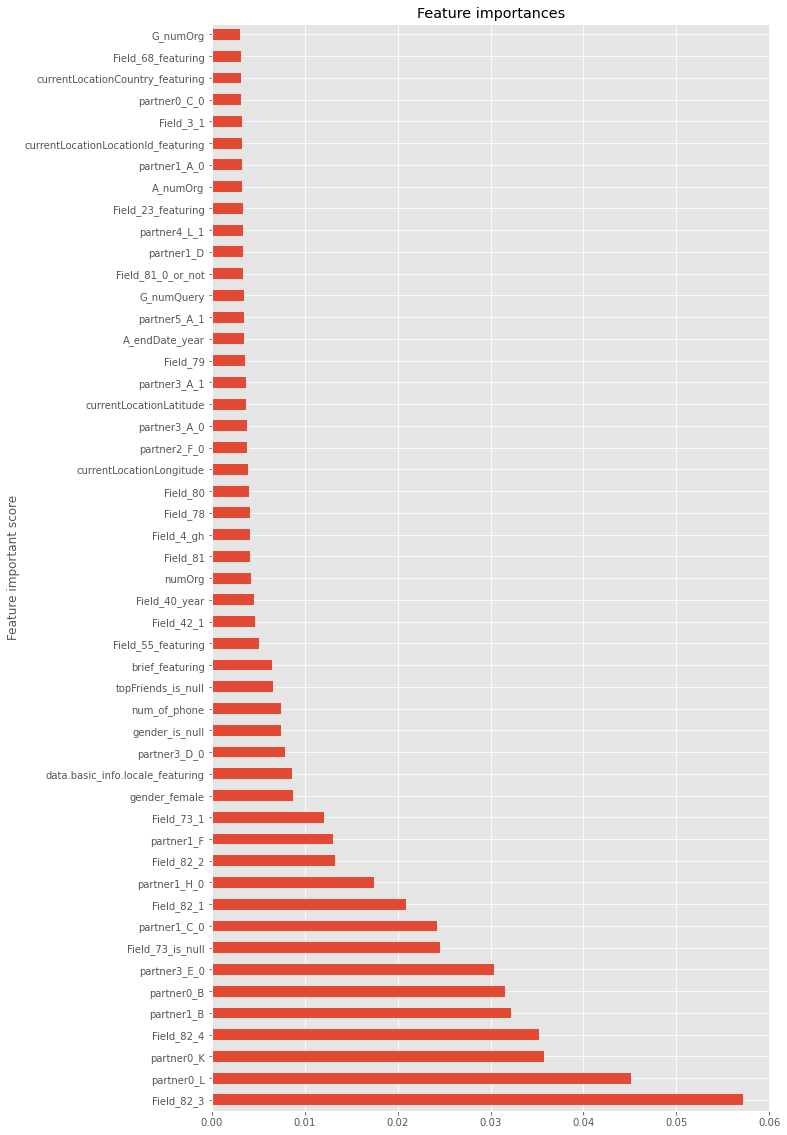

In [92]:
plt.figure(figsize = (10, 20))
arr = xgb_model.feature_importances_
df_imp = pd.Series(arr, cols).sort_values(ascending=False)
df_imp[:50].plot(kind = 'barh', title = 'Feature importances')
plt.ylabel('Feature important score')

In [93]:
# y_pre = xgb_model.predict_proba(test_fe)

In [ ]:
df_test["label"] = pred
df_test[['id', 'label']].to_csv('submission_version3.csv', index=False)

## MLP classifier